# Simulations on Real Data from Fairhaven/New Bedford Deployment

In [1]:
# Imports
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib import cm
from sklearn import mixture
from IPython.display import display
from scipy.stats import multivariate_normal
import numpy as np
import scipy as sp
import math
import os
import GPy as GPy
import dubins
import time
from itertools import chain
import ipp_library

# necessary imports
import pandas as pd
from matplotlib.image import NonUniformImage
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import seaborn as sns
from descartes import PolygonPatch
from shapely.geometry import LineString
from scipy.optimize import curve_fit
# import sensor_plotting as sp

%matplotlib inline
%pylab inline

pd.set_option('display.max_columns',None)
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15

Populating the interactive namespace from numpy and matplotlib


 /home/vpreston/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning:pylab import has clobbered these variables: ['multivariate_normal']
`%matplotlib` prevents importing * from pylab and numpy


In [2]:
# all_data = './jetyak_new_bedford/cleandata/all_interpolated.csv'
# fh_data = './jetyak_new_bedford/cleandata/fh_interpolated.csv'
# nb_data = './jetyak_new_bedford/cleandata/nb_interpolated.csv'

# ctd_geo = './jetyak_new_bedford/cleandata/ctd_geo.csv'
# gga_geo = './jetyak_new_bedford/cleandata/gga_geo.csv'
# nit_geo = './jetyak_new_bedford/cleandata/nit_geo.csv'
# op_geo = './jetyak_new_bedford/cleandata/op_geo.csv'
# air_geo = './jetyak_new_bedford/cleandata/air_geo.csv'


all_data = '../nb-effluent-plumes/data/clean/all_interpolated.csv'
fh_data = '../nb-effluent-plumes/data/clean/fh_interpolated.csv'
nb_data = '../nb-effluent-plumes/data/clean/nb_interpolated.csv'

ctd_geo = '../nb-effluent-plumes/data/clean/ctd_geo.csv'
gga_geo = '../nb-effluent-plumes/data/clean/gga_geo.csv'
nit_geo = '../nb-effluent-plumes/data/clean/nit_geo.csv'
op_geo = '../nb-effluent-plumes/data/clean/op_geo.csv'
air_geo = '../nb-effluent-plumes/data/clean/air_geo.csv'



In [3]:
all_df = pd.read_table(all_data, delimiter=',', header=[0,1])
fh_df = pd.read_table(fh_data, delimiter=',', header=[0,1])
nb_df = pd.read_table(nb_data, delimiter=',', header=[0,1])

ctd_df = pd.read_table(ctd_geo, delimiter=',', header=[0,1])
gga_df = pd.read_table(gga_geo, delimiter=',', header=[0,1])
nit_df = pd.read_table(nit_geo, delimiter=',', header=[0,1])
air_df = pd.read_table(air_geo, delimiter=',', header=[0,1])
op_df = pd.read_table(op_geo, delimiter=',', header=[0,1])

 /home/vpreston/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:Columns (0,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
 /home/vpreston/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:Columns (0,18,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
 /home/vpreston/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.


(1458, 2) (1458, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    01s07  0006   6.392139e+03   1.976157e+05 
    03s24  0018   4.773941e+03   2.441761e-03 
    05s39  0030   4.773409e+03   9.878163e-01 
    06s82  0038   4.772501e+03   4.100327e-09 
Runtime:     06s82
Optimization status: Converged

Optimization restart 1/2, f = 4772.50086267
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    01s02  0005   9.500392e+02   1.044572e+04 
    03s08  0015   8.448126e+02   2.119472e+01 
    04s70  0023   8.445479e+02   4.674809e-08 
Runtime:     04s70
Optimization status: Converged

Optimization restart 2/2, f = 844.547911882
  rbf.         |               value  |  constraints  |  priors
  variance     |  12.932614445024047  |      +ve      |        
  lengthscale  |   4.100333962700088  |      +ve      |        


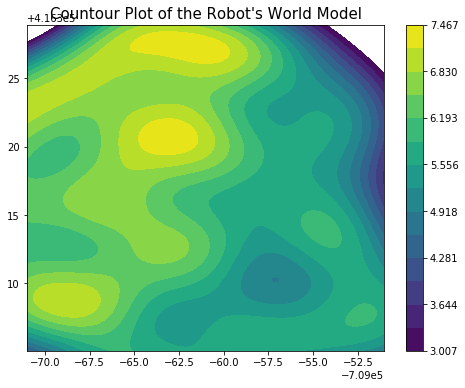

In [4]:
fh_d = fh_df.loc[fh_df['p'].drop_duplicates(subset=['Longitude']).dropna().index]
fh_d = fh_d.loc[fh_d['gga'].dropna(subset=['CO2_ppm_adjusted']).index]
fh_d = fh_d[fh_d['p']['Latitude'] < 41.634]
fh_d = fh_d[fh_d['p']['Latitude'] > 41.6305]
fh_d = fh_d[fh_d['p']['Longitude'] > -70.9071]
fh_d = fh_d[fh_d['ctd']['Depth'] > 0.2]
fh_d = fh_d[fh_d['ctd']['Depth'] < 0.5]
fh_d = fh_d[fh_d['gga']['CH4_ppm_adjusted'] < 8.5]


# ctd_fh = ctd_df.drop(ctd_df[ctd_df.Julian_Date > (0.205+2458207)].index)
# ctd_nb = ctd_df.drop(ctd_df[ctd_df.Julian_Date < (0.231+2458207)].index)
# fh_d = fh_d.dropna()

xv = fh_d['p']['Longitude'][:]
yv = fh_d['p']['Latitude'][:]
z = fh_d['gga']['CH4_ppm_adjusted'][:]

# plt.scatter(xv*100, yv*100)

ranges = [min(xv)*10000, max(xv)*10000, min(yv)*10000, max(yv)*10000]

points = []
for x,y in zip(xv, yv):
    points.append([x*10000,y*10000])

xvals = np.array(points)
zvals = np.reshape(np.array(z), (len(z), 1))
print xvals.shape, zvals.shape

kern = GPy.kern.RBF(input_dim = 2, lengthscale=0.001, variance=np.var(z))
mod = GPy.models.GPRegression(xvals, zvals, kern)
mod.initialize_parameter()
mod.optimize_restarts(num_restarts = 2, messages = True)
print kern

xc = np.linspace(ranges[0], ranges[1], 100)
yc = np.linspace(ranges[2], ranges[3], 100)
xc, yc = np.meshgrid(xc, yc, sparse = False, indexing= 'xy')
data = np.vstack([xc.ravel(), yc.ravel()]).T
obs, var = mod.predict(data, full_cov=False, include_likelihood=True)

fig2, ax2 = plt.subplots(figsize=(8, 6))
ax2.set_xlim(ranges[0:2])
ax2.set_ylim(ranges[2:])       
ax2.set_title('Countour Plot of the Robot\'s World Model')     
plot = ax2.contourf(xc, yc, obs.reshape(xc.shape), cmap = 'viridis', levels=np.linspace(min(z), max(z), 15), vmin=min(z), vmax=max(z))
# ax2.scatter(xc, yc, c=obs.reshape(xc.shape), cmap = 'viridis', levels=np.linspace(min(z), max(z), 15), vmin=min(z), vmax=max(z))
ax2.scatter(xv, yv, c=z, cmap='viridis', vmin=min(z), vmax=max(z))
ax2.plot(-70.90668, 41.63118, 'r*', markersize=10)
cbar = fig2.colorbar(plot)

(1458, 2) (1458, 1)
19.965 23.853
6.370657765702211 0.3330176189875886
World max value 7.467374396955659 at location [-709064.919  416322.422]
(-709061.0165000001, 416316.99750000006, 0)
[ 0 ] Current Location:   (-709065.0165000001, 416322.99750000006, 0)


 ipp_library.py:611: RuntimeWarning:divide by zero encountered in log
 ipp_library.py:611: RuntimeWarning:invalid value encountered in sqrt
 ipp_library.py:611: RuntimeWarning:invalid value encountered in double_scalars
 ipp_library.py:611: RuntimeWarning:divide by zero encountered in double_scalars


Number of rollouts: 4341 	 Size of tree: 12501
Current predicted max and value: 	[[0. 0.]] 	0.0
Optimizing kernel parameters given data
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0004   1.486477e+01   4.048609e+01 
    00s02  0009   4.941017e+00   1.053711e-01 
    00s03  0014   3.439767e+00   2.342026e-04 
    00s05  0021   3.335791e+00   3.278256e-11 
Runtime:     00s05
Optimization status: Converged

Optimization restart 1/2, f = 3.3357907974
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0004   5.642511e+00   3.008929e-01 
    00s02  0011   3.375424e+00   5.057342e-05 
    00s03  0015   3.335800e+00   4.215483e-09 
    00s04  0017   3.335791e+00   1.701461e-11 
Runtime:     00s04
Optimization status: Converged

Optimization restart 2/2, f = 3.33579076376
[ 1 ] Current Location:   (-709063.6910076537, 416320.30620476545, -1.1131578947368421)
Number of rollouts: 4166 	 

 ipp_library.py:1649: RuntimeWarning:invalid value encountered in sqrt



Runtime:     00s06
Optimization status: Converged

Optimization restart 2/2, f = 3.97347972874
[ 2 ] Current Location:   (-709062.043618259, 416322.8134160015, 0.9894736842105263)
Number of rollouts: 4116 	 Size of tree: 11835
Current predicted max and value: 	[-709063.42606897  416321.52134483] 	27.170396825473194
Optimizing kernel parameters given data
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0001   4.022797e+00   3.494235e-04 
    00s00  0003   3.949293e+00   1.143988e-04 
    00s02  0010   3.912231e+00   2.772880e-11 
Runtime:     00s02
Optimization status: Converged

Optimization restart 1/2, f = 3.91223132504
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   1.109126e+02   2.772880e-11 
    00s00  0001   1.109126e+02   6.113224e+03 
    00s01  0005   2.518489e+01   2.717001e+01 
    00s03  0012   1.069393e+01   6.591498e-03 
    00s05  0021   1.007990e+01   3

    00s01  0005   8.612477e+00   5.207376e-05 
    00s03  0012   8.607343e+00   8.480543e-07 
    00s04  0015   8.607343e+00   4.520470e-12 
Runtime:     00s04
Optimization status: Converged

Optimization restart 1/2, f = 8.60734250555
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0004   4.158144e+01   4.602547e+02 
    00s02  0010   1.016599e+01   4.578322e-01 
    00s04  0017   8.607358e+00   7.231237e-06 
    00s05  0022   8.607343e+00   2.112650e-13 
Runtime:     00s05
Optimization status: Converged

Optimization restart 2/2, f = 8.60734250555
[ 11 ] Current Location:   (-709064.1512311193, 416322.41141398886, -11.255263157894737)
few paths available!
few paths available!
few paths available!
Number of rollouts: 944 	 Size of tree: 3430
Current predicted max and value: 	[-709063.42606897  416320.69882759] 	6.244752578377935
Optimizing kernel parameters given data
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    

    00s00  0003   9.813929e+00   2.652731e-03 
    00s02  0009   9.813594e+00   1.829184e-06 
    00s06  0023   9.813594e+00   2.959906e-10 
Runtime:     00s06
Optimization status: Converged

Optimization restart 1/2, f = 9.81359428738
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0010   1.170944e+01   4.481064e+00 
    00s05  0018   9.813594e+00   6.952794e-11 
    00s05  0019   9.813594e+00   6.952794e-11 
Runtime:     00s05
Optimization status: Converged

Optimization restart 2/2, f = 9.81359428735
[ 19 ] Current Location:   (-709065.797003554, 416312.08019082836, -14.223684210526317)
Number of rollouts: 886 	 Size of tree: 3194
Current predicted max and value: 	[-709063.42606897  416320.69882759] 	7.224244620642796
Optimizing kernel parameters given data
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0001   1.056939e+01   1.710118e+00 
    00s02  0008   1.051495e+01   2.

    00s02  0008   1.988416e+01   2.186902e+01 
    00s04  0016   1.916376e+01   5.006653e-08 
    00s04  0019   1.916376e+01   1.934640e-08 
Runtime:     00s04
Optimization status: Converged

Optimization restart 2/2, f = 19.1637632581
[ 27 ] Current Location:   (-709052.4019400164, 416313.11410686193, -11.502631578947367)
Number of rollouts: 929 	 Size of tree: 3016
Current predicted max and value: 	[-709063.42606897  416320.69882759] 	7.259492993194631
Optimizing kernel parameters given data
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0006   1.972944e+01   1.075434e-02 
    00s02  0009   1.972640e+01   1.567326e-02 
    00s03  0014   1.972610e+01   1.443154e-10 
Runtime:     00s03
Optimization status: Converged

Optimization restart 1/2, f = 19.7261016907
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0005   2.945334e+01   3.977855e+01 
    00s02  0010   1.980088e+01   3

    00s05  0019   2.333000e+01   2.013564e+01 
    00s06  0025   2.286084e+01   1.036195e-12 
    00s12  0045   2.286084e+01   4.371197e-06 
    00s12  0047   2.286084e+01   8.074369e-13 
Runtime:     00s12
Optimization status: Converged

Optimization restart 2/2, f = 22.8608432293
[ 35 ] Current Location:   (-709061.4935486763, 416328.77400000003, -10.018421052631577)
Number of rollouts: 869 	 Size of tree: 2922
Current predicted max and value: 	[-709063.42606897  416319.87631034] 	7.0985889015889105
Optimizing kernel parameters given data
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0005   2.434089e+01   2.876438e-02 
    00s03  0014   2.429372e+01   7.068218e-11 
Runtime:     00s03
Optimization status: Converged

Optimization restart 1/2, f = 24.2937232338
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0005   3.937631e+01   1.305553e+02 
    00s02  0010   2.463491e+01   

    00s03  0012   2.502086e+01   4.401751e-11 
Runtime:     00s03
Optimization status: Converged

Optimization restart 1/2, f = 25.020861628
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0006   4.786817e+01   3.217713e+02 
    00s02  0007   4.103231e+01   1.781702e+02 
    00s03  0013   2.502241e+01   1.787301e-01 
    00s04  0017   2.502086e+01   5.270494e-10 
Runtime:     00s04
Optimization status: Converged

Optimization restart 2/2, f = 25.0208616282
[ 44 ] Current Location:   (-709069.6822492364, 416305.38891636016, -8.163157894736841)
Number of rollouts: 901 	 Size of tree: 2886
Current predicted max and value: 	[-709063.42606897  416319.87631034] 	6.820774070547536
Optimizing kernel parameters given data
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0006   2.600909e+01   1.429197e-02 
    00s03  0012   2.600817e+01   1.742950e-09 
Runtime:     00s03
Optimization stat

Number of rollouts: 880 	 Size of tree: 3120
Current predicted max and value: 	[-709063.42606897  416319.87631034] 	7.271115525329645
Optimizing kernel parameters given data
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   1.121632e+01           nan 
    00s01  0006   1.121604e+01   1.218471e-03 
    00s03  0011   1.121596e+01   9.002977e-10 
    00s03  0012   1.121596e+01   9.002977e-10 
Runtime:     00s03
Optimization status: Converged

Optimization restart 1/2, f = 11.21595755
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0002   1.297524e+03   7.002903e+05 
    00s02  0008   4.612524e+01   1.950814e+03 
    00s06  0022   1.121596e+01   1.442622e-09 
Runtime:     00s06
Optimization status: Converged

Optimization restart 2/2, f = 11.2159575499
[ 53 ] Current Location:   (-709063.3529060261, 416324.5292853949, -4.823684210526315)
Number of rollouts: 892 	 Size of tree:

Number of rollouts: 858 	 Size of tree: 2604
Current predicted max and value: 	[-709063.42606897  416319.87631034] 	7.15861514835071
[ 70 ] Current Location:   (-709062.5274317111, 416328.77400000003, 1.2368421052631609)
Number of rollouts: 864 	 Size of tree: 2983
Current predicted max and value: 	[-709063.42606897  416319.87631034] 	7.158474071298295
[ 71 ] Current Location:   (-709061.2019393647, 416326.08270476543, -1.1131578947368392)
Number of rollouts: 789 	 Size of tree: 2772
Current predicted max and value: 	[-709063.42606897  416319.87631034] 	7.15817105117593
[ 72 ] Current Location:   (-709063.0306527244, 416323.7045106086, -2.2263157894736816)
Number of rollouts: 823 	 Size of tree: 2857
Current predicted max and value: 	[-709063.42606897  416319.87631034] 	7.1590590752171614
[ 73 ] Current Location:   (-709063.1419224272, 416320.70657480985, -1.6078947368421024)
Number of rollouts: 823 	 Size of tree: 2899
Current predicted max and value: 	[-709063.42606897  416319.876310

Number of rollouts: 795 	 Size of tree: 2809
Current predicted max and value: 	[-709063.42606897  416319.87631034] 	7.194414698020015
[ 107 ] Current Location:   (-709064.116180713, 416320.8383939084, -8.039473684210522)
Number of rollouts: 799 	 Size of tree: 2989
Current predicted max and value: 	[-709063.42606897  416319.87631034] 	7.195641730926683
[ 108 ] Current Location:   (-709065.8251816536, 416323.30402076285, -10.389473684210522)
Number of rollouts: 807 	 Size of tree: 2790
Current predicted max and value: 	[-709063.42606897  416319.87631034] 	7.195875284490715
[ 109 ] Current Location:   (-709063.2978646402, 416324.9203959403, -11.997368421052627)
Number of rollouts: 786 	 Size of tree: 2778
Current predicted max and value: 	[-709063.42606897  416319.87631034] 	7.19580903719076
[ 110 ] Current Location:   (-709063.9238354878, 416321.98642925714, -14.347368421052627)
Number of rollouts: 747 	 Size of tree: 2742
Current predicted max and value: 	[-709063.42606897  416319.8763

[ 143 ] Current Location:   (-709062.7510657535, 416322.70254743245, -24.11842105263158)
Number of rollouts: 688 	 Size of tree: 2574
Current predicted max and value: 	[-709063.42606897  416320.69882759] 	7.204523663215655
[ 144 ] Current Location:   (-709062.1979773255, 416325.65112220525, -23.74736842105263)
Number of rollouts: 708 	 Size of tree: 2448
Current predicted max and value: 	[-709063.42606897  416320.69882759] 	7.204687798776155
[ 145 ] Current Location:   (-709060.6133854052, 416328.1984872058, -24.11842105263158)
Number of rollouts: 737 	 Size of tree: 2326
Current predicted max and value: 	[-709063.42606897  416320.69882759] 	7.20466460719666
[ 146 ] Current Location:   (-709060.113766519, 416328.77400000003, -22.510526315789473)
Number of rollouts: 728 	 Size of tree: 2501
Current predicted max and value: 	[-709063.42606897  416320.69882759] 	7.204610669047322
[ 147 ] Current Location:   (-709061.5051657058, 416326.11617978354, -20.902631578947368)
Number of rollouts: 

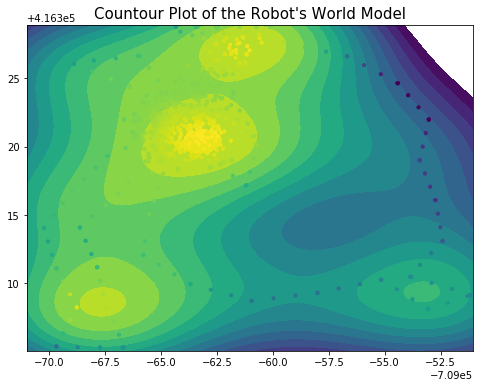

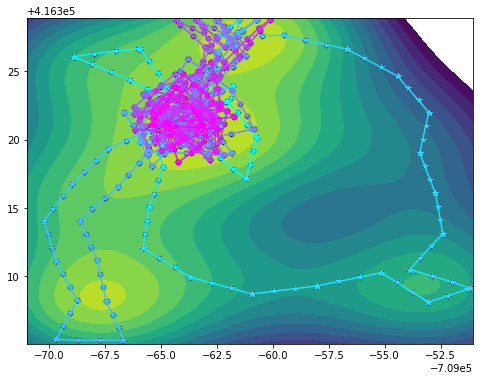

 ipp_library.py:1366: RuntimeWarning:divide by zero encountered in divide
 ipp_library.py:1371: RuntimeWarning:invalid value encountered in divide


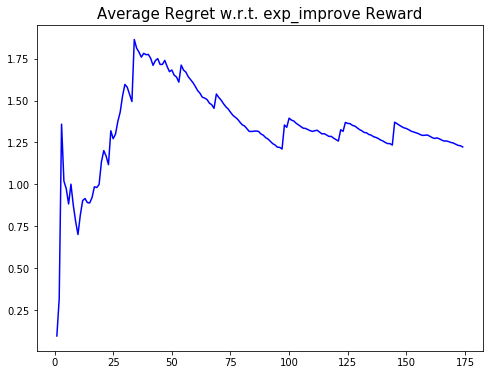

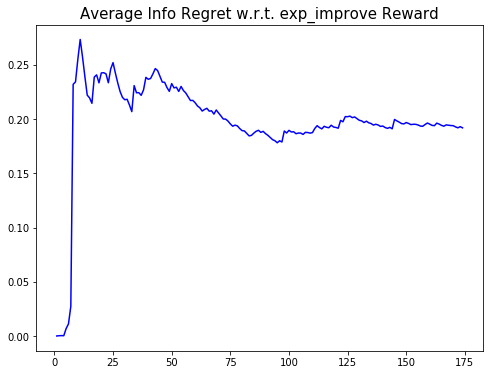

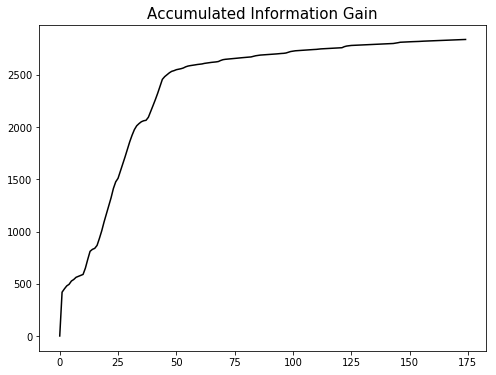

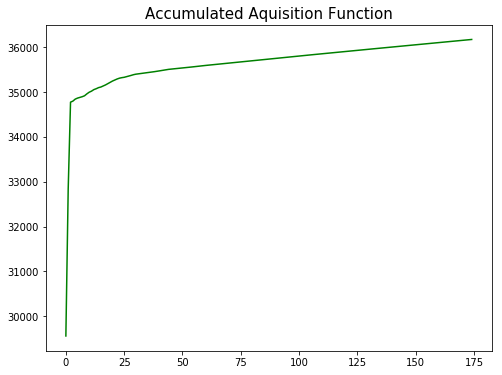

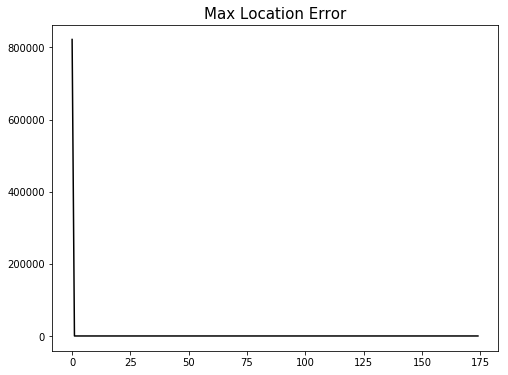

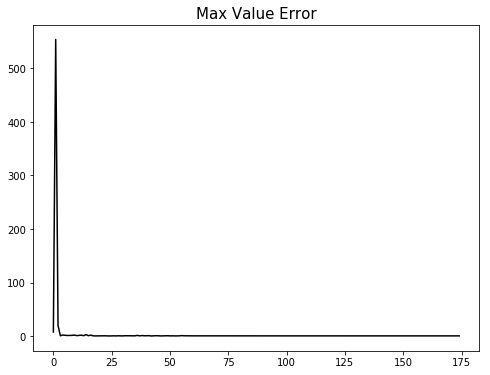

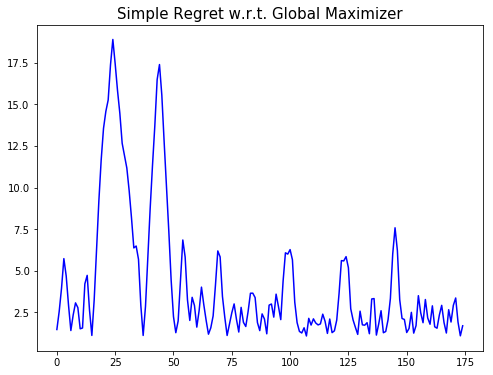

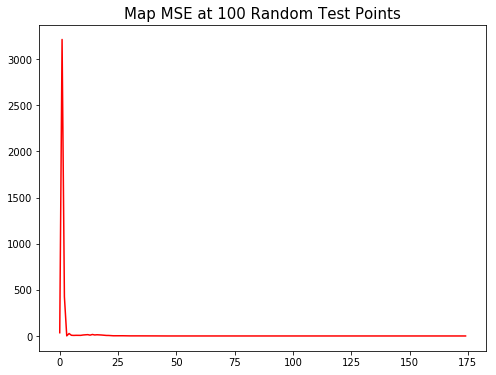

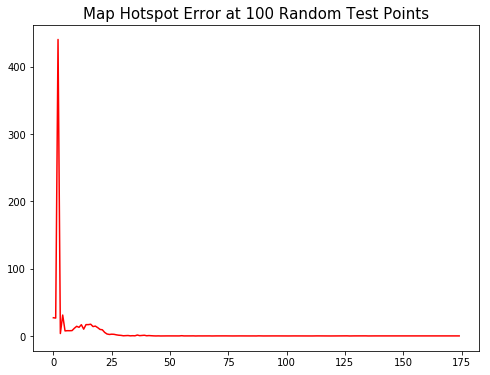

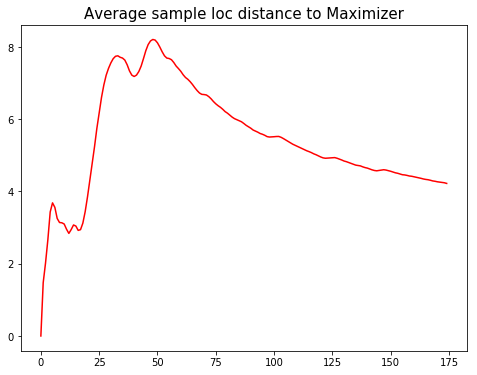

In [5]:
reload(ipp_library)
from ipp_library import *

# Create a random enviroment sampled from a GP with an RBF kernel and specified hyperparameters, mean function 0 
# The enviorment will be constrained by a set of uniformly distributed  sample points of size NUM_PTS x NUM_PTS
''' Options include mean, info_gain, hotspot_info, and mes'''
xv = fh_d['p']['Longitude'][:]
yv = fh_d['p']['Latitude'][:]
z = fh_d['gga']['CH4_ppm_adjusted'][:]

LENGTH = 0.001#12.76#4.10
VAR = np.var(z)#20.47#12.93#

# plt.scatter(xv*100, yv*100)

points = []
for x,y in zip(xv, yv):
    points.append([x*10000,y*10000])

xvals = np.array(points)
zvals = np.reshape(np.array(z), (len(z), 1))
print xvals.shape, zvals.shape
print max(xv)*10000 - min(xv)*10000, max(yv)*10000 - min(yv)*10000
print np.mean(zvals), np.var(zvals)

ranges = (min(xv)*10000, max(xv)*10000, min(yv)*10000, max(yv)*10000)

reward_function = 'exp_improve'
gp_world = GPModel(ranges, 4.10, 12.93)
gp_world.add_data(xvals, zvals)

world = Environment(ranges = ranges, # x1min, x1max, x2min, x2max constraints
                    NUM_PTS = 20, 
                    variance = 12.93, 
                    lengthscale = 4.10, 
                    visualize = True,
                    seed = None,
                    model = gp_world)

evaluation = Evaluation(world = world, reward_function = reward_function)

# Gather some prior observations to train the kernel (optional)
x1observe = np.linspace(-709070.99900000007, -709051.0340000001, 20)
x2observe = np.linspace(416305.07100000005, 416328.92400000006, 20)
x1observe, x2observe = np.meshgrid(x1observe, x2observe, sparse = False, indexing = 'xy')  
data = np.vstack([x1observe.ravel(), x2observe.ravel()]).T
observations = world.sample_value(data)

print ((min(xv)*10000+max(xv)*10000)/2, (min(yv)*10000+max(yv)*10000)/2, 0)

# Create the point robot
#obot.__class__ = Nonmyopic_Robot
robot = Nonmyopic_Robot(sample_world = world.sample_value, 
              start_loc = ((min(xv)*10000+max(xv)*10000)/2-4, (min(yv)*10000+max(yv)*10000)/2+6, 0), 
              extent = ranges,
              kernel_file = None,
              kernel_dataset = None,
              prior_dataset =  None, 
              #prior_dataset =  (data, observations), 
              init_lengthscale = LENGTH, 
              init_variance = VAR, 
              noise = 0.0001,
              path_generator = 'dubins',
              frontier_size = 20, 
              horizon_length = 3.0, 
              turning_radius = 0.05,
              sample_step = 1.0,
              evaluation = evaluation, 
              f_rew = reward_function, 
              create_animation = True,
              computation_budget = 10.0,
              rollout_length = 5) 

robot.planner(T = 175)
robot.visualize_world_model(screen = True)
robot.visualize_trajectory(screen = True)
robot.plot_information()
